Number of unique posts: 4349970
Embedding dimension: 128


100%|██████████| 19/19 [00:25<00:00,  1.34s/it]


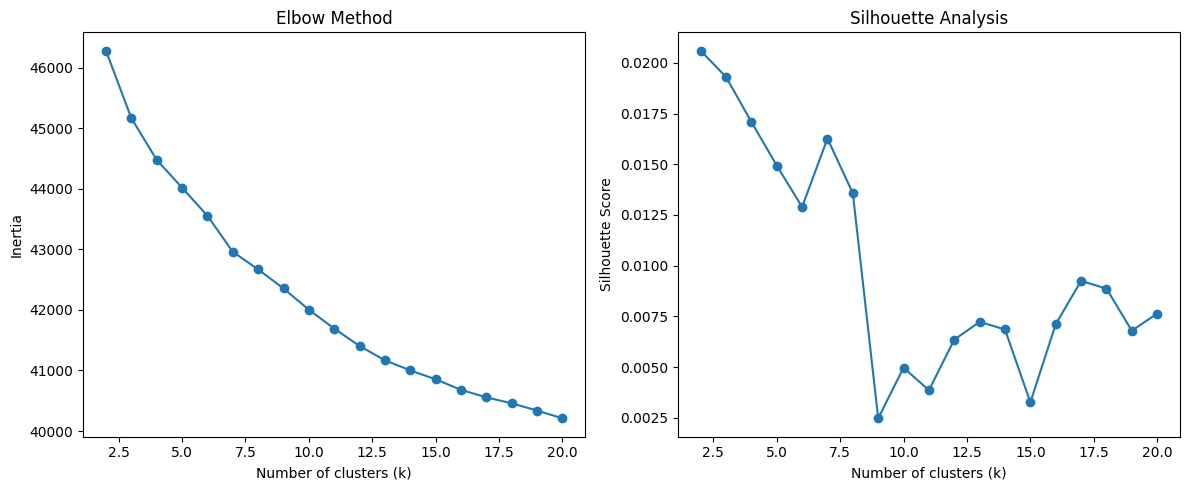

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import MiniBatchKMeans  # Changed to MiniBatchKMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the data
df = pd.read_parquet("data/bluesky_text_embeddings (2).parquet")

# Get unique posts and their embeddings - using more efficient pandas operations
post_data = df[['item_id', 'embeddings']].drop_duplicates('item_id', ignore_index=True)
post_embeddings = np.vstack(post_data['embeddings'].values)  # vstack is more efficient than stack
post_ids = post_data['item_id'].values

print(f"Number of unique posts: {len(post_ids)}")
print(f"Embedding dimension: {post_embeddings.shape[1]}")

# Take a random sample for finding optimal k (10% of data)
sample_size = min(100000, len(post_embeddings))
random_indices = np.random.choice(len(post_embeddings), sample_size, replace=False)
sample_embeddings = post_embeddings[random_indices]

# Find optimal number of clusters using elbow method and silhouette score
max_clusters = 20
inertias = []
silhouette_scores = []

# Use MiniBatchKMeans for faster clustering
for k in tqdm(range(2, max_clusters + 1)):
    kmeans = MiniBatchKMeans(
        n_clusters=k,
        batch_size=1024,  # Larger batch size for faster processing
        random_state=42,
        n_init='auto'     # Let sklearn choose optimal number of initializations
    )
    kmeans.fit(sample_embeddings)
    inertias.append(kmeans.inertia_)
    
    # Calculate silhouette score on a smaller random subset for speed
    subset_size = min(10000, len(sample_embeddings))
    subset_indices = np.random.choice(len(sample_embeddings), subset_size, replace=False)
    silhouette_scores.append(
        silhouette_score(
            sample_embeddings[subset_indices],
            kmeans.labels_[subset_indices],
            sample_size=subset_size
        )
    )

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_clusters + 1), inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.tight_layout()
plt.show()

In [ ]:
# Perform final clustering on full dataset with optimal k
optimal_k = 10000  # Adjust based on plots
final_kmeans = MiniBatchKMeans(
    n_clusters=optimal_k,
    batch_size=4096,     # Large batch size for final clustering
    random_state=42,
    n_init='auto'
)
cluster_labels = final_kmeans.fit_predict(post_embeddings)

# Add cluster labels to the dataframe
post_data['cluster'] = cluster_labels

# Analyze clusters
print("\nCluster Sizes:")
print(pd.Series(cluster_labels).value_counts().sort_index())

# More efficient implementation of get_cluster_representatives
def get_cluster_representatives(cluster_id, n=5):
    cluster_mask = post_data['cluster'] == cluster_id
    cluster_posts = post_data[cluster_mask]
    cluster_embeddings = np.vstack(cluster_posts['embeddings'].values)
    
    # Vectorized distance calculation
    centroid = final_kmeans.cluster_centers_[cluster_id]
    distances = np.linalg.norm(cluster_embeddings - centroid, axis=1)
    
    # Get top n closest
    closest_indices = np.argpartition(distances, n)[:n]
    return cluster_posts.iloc[closest_indices]

# Print representative posts for each cluster
print("\nCluster Representatives:")
for cluster_id in range(optimal_k):
    print(f"\nCluster {cluster_id}:")
    representatives = get_cluster_representatives(cluster_id)
    for _, post in representatives.iterrows():
        print(f"Post ID: {post['item_id']}")

In [2]:
import pickle

optimal_k = 8

# Load post mapping from pickle file
with open('data/post_mapping.pkl', 'rb') as f:
    post_mapping = pickle.load(f)

# Create reverse mapping
reverse_post_mapping = {v: k for k, v in post_mapping.items()}

def get_post_url(post_id):
    """Convert post ID to URL using the post_mapping"""
    if post_id in reverse_post_mapping:
        full_id = reverse_post_mapping[post_id]
        did, post_ref = full_id.split('_')
        return f"https://bsky.app/profile/{did}/post/{post_ref}"
    return f"Post ID: {post_id} (not found in mapping)"

# Print representative posts for each cluster
print("\nCluster Representatives:")
for cluster_id in range(optimal_k):
    print(f"\nCluster {cluster_id}:")
    representatives = get_cluster_representatives(cluster_id)
    for _, post in representatives.iterrows():
        print(get_post_url(post['item_id']))


Cluster Representatives:

Cluster 0:


NameError: name 'get_cluster_representatives' is not defined